In [1]:
import os
import time
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn as nil
from nilearn import plotting
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
# ensure directory structure includes 'nitorch' from https://github.com/moboehle/Pytorch-LRP/tree/master/nitorch,
# as there are other packages named 'nitorch' that will not work here
from nitorch import callbacks, trainer, inference, metrics
from nitorch.metrics import balanced_accuracy
from nitorch.callbacks import ModelCheckpoint, EarlyStopping

seed = 1234

# Read in data
## Ensure that file paths match your directory structure
## Files must be in .nii format

In [2]:
# useful BASH command for moving files from ADNI download: find ADNI -type f -exec mv -t . {} +
dir = ('C:/Users/Ben/Desktop/Collection1/Baseline/Data/') # change this to directory with PET images     
files = os.listdir(dir)

# read in CSV description of downloaded PET scans
df = pd.read_csv('C:/Users/Ben/Desktop/Collection1/Baseline_PET_All_3_20_2021.csv')

# create x and y arrays
group = []
for i in range(len(files)):
    idx = files[i][5:15]
    group.append(df.loc[df.Subject==idx,'Group'].values[0]) 
group = ((np.array(group) == 'AD') / 1)
ims = np.array([nib.load(dir + file).get_fdata() for file in files])

# Build an ensemble based on specified slices
## Make to specify a directory to save the sub-models in the `model_path` field

In [3]:
for z_slice in range(30, 70, 4):
    print('Starting slice {}'.format(z_slice))
    # format data for pytorch
    if type(ims) != torch.Tensor: 
        ims = torch.from_numpy(ims).float()
    x = torch.moveaxis(ims[:,:,:,z_slice], -1, 1)

    # randomly create holdout set
    x_tmp, x_test, y_tmp, y_test = train_test_split(x, 
                                                    group, 
                                                    test_size = .1, 
                                                    shuffle = True, 
                                                    stratify = group, 
                                                    random_state = seed) 

    #create train/val split
    x_train, x_val, y_train, y_val = train_test_split(x_tmp, 
                                                      y_tmp, 
                                                      test_size = .1, 
                                                      shuffle = True, 
                                                      stratify = y_tmp, 
                                                      random_state = z_slice)

    # min max normalization
    for i in range(len(x_train)):
        x_train[i] -= torch.min(x_train[i])
        x_train[i] /= torch.max(x_train[i])
    for i in range(len(x_val)):
        x_val[i] -= torch.min(x_val[i])
        x_val[i] /= torch.max(x_val[i])
    print(x_train.shape)
    print(x_val.shape)
    print(y_train.shape)
    print(y_val.shape)
    print(sum(y_train))
    print(sum(y_val))

    # https://github.com/moboehle/Pytorch-LRP/blob/master/ADNI%20Training.ipynb
    class ADNIDataset(Dataset):
        def __init__(self, X, y, transform=None, target_transform=None, mask=None, z_factor=None, dtype=torch.float32, num_classes=2):
            self.X = np.copy(X)
            self.y = np.copy(y)
            self.X = X
            self.y = y
            self.transform = transform
            self.target_transform = target_transform
            self.mask = mask
            self.z_factor = z_factor
            self.dtype = dtype
            self.num_classes = num_classes

        def __len__(self):
            return len(self.X)

        def __getitem__(self, idx):
            image = self.X[idx]
            label_tensor = np.zeros(shape=(self.num_classes,))
            label = self.y[idx] >= 0.5
            label = torch.LongTensor([label])

            if self.transform:
                image = self.transform(image)

            sample = {"image" : image,
                     "label" : label}
            return sample

    adni_data_train = ADNIDataset(x_train, y_train)
    adni_data_val = ADNIDataset(x_val, y_val)

    # https://github.com/moboehle/Pytorch-LRP/blob/master/ADNI%20Training.ipynb for reference
    class ClassificationModel2D(nn.Module):

        def __init__(self, dropout=0.4, dropout2=0.4):
            nn.Module.__init__(self)
            self.Conv_1 = nn.Conv2d(1, 8, 3)
            self.Conv_1_bn = nn.BatchNorm2d(8)
            self.Conv_1_mp = nn.MaxPool2d(2)
            self.Conv_2 = nn.Conv2d(8, 16, 3)
            self.Conv_2_bn = nn.BatchNorm2d(16)
            self.Conv_2_mp = nn.MaxPool2d(3)
            self.Conv_3 = nn.Conv2d(16, 32, 3)
            self.Conv_3_bn = nn.BatchNorm2d(32)
            self.Conv_3_mp = nn.MaxPool2d(2)
            self.Conv_4 = nn.Conv2d(32, 64, 3)
            self.Conv_4_bn = nn.BatchNorm2d(64)
            self.Conv_4_mp = nn.MaxPool2d(3)
            self.dense_1 = nn.Linear(576, 128)
            self.dense_2 = nn.Linear(128, 2)
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(dropout)
            self.dropout2 = nn.Dropout(dropout2)

        def forward(self, x):
            x = self.relu(self.Conv_1_bn(self.Conv_1(x)))
            x = self.Conv_1_mp(x)
            x = self.relu(self.Conv_2_bn(self.Conv_2(x)))
            x = self.Conv_2_mp(x)
            x = self.relu(self.Conv_3_bn(self.Conv_3(x)))
            x = self.Conv_3_mp(x)
            x = self.relu(self.Conv_4_bn(self.Conv_4(x)))
            x = self.Conv_4_mp(x)
            x = x.view(x.size(0), -1)
            x = self.dropout(x)
            x = self.relu(self.dense_1(x))
            x = self.dropout2(x)
            x = self.dense_2(x)
            return x

    net = ClassificationModel2D()

    # https://github.com/moboehle/Pytorch-LRP/blob/master/ADNI%20Training.ipynb
    def run(
        net,
        data,
        shape,
        callbacks=[],
        augmentations=[],
        masked=False,
        metrics=[],
        k_folds=None,
        b=4,
        num_epochs=35,
        retain_metric=None):      

        fold_metric = []
        models = []
        fold = 0
        initial_prepend = None

        for trial in range(5):
            print("Starting trial {}".format(trial))

            # add current fold number to model checkpoint path
            if callbacks is not None:
                for idx, callback in enumerate(callbacks):
                    if isinstance(callback, ModelCheckpoint):
                        if initial_prepend is None:
                            initial_prepend = callbacks[idx].prepend
                        callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
            fold += 1

            # restart model
            del net
            net = ClassificationModel2D()

            # reset hyperparameters
            lr = 1e-4
            wd = 1e-4
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

            train_loader = DataLoader(adni_data_train, batch_size=b, num_workers=0, shuffle=True)
            val_loader = DataLoader(adni_data_val, batch_size=1, num_workers=0, shuffle=True)

            # plot slice (optional)
            #sample = next(iter(train_loader))
            #img = sample["image"][0]
            #lbl = sample["label"][0]
            #plt.imshow(img.squeeze(), cmap='gray')
            #plt.title(lbl.item())
            #plt.show()
            model_trainer = trainer.Trainer(
                net,
                criterion,
                optimizer,
                metrics=metrics,
                callbacks=callbacks,
                device=torch.device("cpu"),
                prediction_type="classification")

            # train model and store results
            net, report = model_trainer.train_model(
                train_loader,
                val_loader,
                num_epochs=num_epochs,
                show_train_steps=60,
                show_validation_epochs=1)
            # append validation score of the retain metric
            if isinstance(retain_metric, str):
                fold_metric.append(report["val_metrics"][retain_metric][-1])
            else:
                fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])

            models.append(net)
            print("Finished fold.")

            # visualize result (optional)
            #model_trainer.visualize_training(report, metrics)
            #model_trainer.evaluate_model(val_loader)

        print("################################")
        print("################################")
        print("All accuracies: {}".format(fold_metric))
        return fold_metric, models

    net = ClassificationModel2D()
    num_epochs = 25
    min_iters = 3
    ignore_epochs = 15
    normalize = False
    retain_metric = accuracy_score
    metrics = [accuracy_score]
    model_path = 'C:/Users/Ben/Desktop/Collection1/torch'
    r = 0

    check = ModelCheckpoint(path=model_path,
                            prepend="repeat_{}".format(r),
                            store_best=True,
                            ignore_before=ignore_epochs,
                            retain_metric=retain_metric)
    callbacks = [check, EarlyStopping(patience=10, ignore_before=ignore_epochs, retain_metric="loss", mode='min')]

    fold_metric, models = run(net=net, data=adni_data_train,
                      k_folds=-1,
                      callbacks=None,
                      shape=-1,
                      masked=False,
                      metrics=metrics,
                      num_epochs=num_epochs,
                      retain_metric=retain_metric,
                      b=4,
                     )

    print(np.mean(fold_metric))
    print(np.std(fold_metric))
    best = np.array(fold_metric).argmax()
    torch.save(models[best].state_dict(), model_path + '/' + '2D_Slice_' + str(z_slice))

Starting slice 30
torch.Size([269, 1, 160, 160])
torch.Size([30, 1, 160, 160])
(269,)
(30,)
43.0
5.0
C:/Users/Ben/Desktop/Collection1/torch
Starting trial 0
[0,    60] loss: 0.49456
Time elapsed: 0h:0m:2s
train accuracy_score: 84.39 %
val accuracy_score: 83.33 %
Val loss: 0.413592
[1,    60] loss: 0.40750
Time elapsed: 0h:0m:5s
train accuracy_score: 85.87 %
val accuracy_score: 86.67 %
Val loss: 0.345086
[2,    60] loss: 0.31610
Time elapsed: 0h:0m:8s
train accuracy_score: 88.10 %
val accuracy_score: 86.67 %
Val loss: 0.297409
[3,    60] loss: 0.26647
Time elapsed: 0h:0m:10s
train accuracy_score: 91.08 %
val accuracy_score: 93.33 %
Val loss: 0.242039
[4,    60] loss: 0.23154
Time elapsed: 0h:0m:13s
train accuracy_score: 92.57 %
val accuracy_score: 93.33 %
Val loss: 0.233176
[5,    60] loss: 0.25819
Time elapsed: 0h:0m:15s
train accuracy_score: 91.82 %
val accuracy_score: 93.33 %
Val loss: 0.215590
[6,    60] loss: 0.25404
Time elapsed: 0h:0m:18s
train accuracy_score: 89.96 %
val accurac

[13,    60] loss: 0.15986
Time elapsed: 0h:0m:35s
train accuracy_score: 95.17 %
val accuracy_score: 93.33 %
Val loss: 0.202880
[14,    60] loss: 0.17661
Time elapsed: 0h:0m:37s
train accuracy_score: 94.42 %
val accuracy_score: 93.33 %
Val loss: 0.220993
[15,    60] loss: 0.10978
Time elapsed: 0h:0m:40s
train accuracy_score: 96.65 %
val accuracy_score: 93.33 %
Val loss: 0.195693
[16,    60] loss: 0.14549
Time elapsed: 0h:0m:42s
train accuracy_score: 95.17 %
val accuracy_score: 93.33 %
Val loss: 0.183402
[17,    60] loss: 0.12642
Time elapsed: 0h:0m:45s
train accuracy_score: 96.28 %
val accuracy_score: 93.33 %
Val loss: 0.218105
[18,    60] loss: 0.09182
Time elapsed: 0h:0m:47s
train accuracy_score: 96.28 %
val accuracy_score: 96.67 %
Val loss: 0.173615
[19,    60] loss: 0.09899
Time elapsed: 0h:0m:50s
train accuracy_score: 97.03 %
val accuracy_score: 93.33 %
Val loss: 0.248391
[20,    60] loss: 0.08988
Time elapsed: 0h:0m:52s
train accuracy_score: 95.54 %
val accuracy_score: 90.00 %
Val

torch.Size([269, 1, 160, 160])
torch.Size([30, 1, 160, 160])
(269,)
(30,)
43.0
5.0
C:/Users/Ben/Desktop/Collection1/torch
Starting trial 0
[0,    60] loss: 0.47190
Time elapsed: 0h:0m:2s
train accuracy_score: 82.53 %
val accuracy_score: 83.33 %
Val loss: 0.431229
[1,    60] loss: 0.42189
Time elapsed: 0h:0m:4s
train accuracy_score: 85.13 %
val accuracy_score: 83.33 %
Val loss: 0.395917
[2,    60] loss: 0.35596
Time elapsed: 0h:0m:7s
train accuracy_score: 85.50 %
val accuracy_score: 86.67 %
Val loss: 0.343177
[3,    60] loss: 0.35278
Time elapsed: 0h:0m:9s
train accuracy_score: 88.48 %
val accuracy_score: 86.67 %
Val loss: 0.357890
[4,    60] loss: 0.31303
Time elapsed: 0h:0m:12s
train accuracy_score: 89.22 %
val accuracy_score: 86.67 %
Val loss: 0.317463
[5,    60] loss: 0.28123
Time elapsed: 0h:0m:14s
train accuracy_score: 89.96 %
val accuracy_score: 86.67 %
Val loss: 0.307300
[6,    60] loss: 0.30103
Time elapsed: 0h:0m:17s
train accuracy_score: 89.96 %
val accuracy_score: 86.67 %
Va

[13,    60] loss: 0.18377
Time elapsed: 0h:0m:34s
train accuracy_score: 93.31 %
val accuracy_score: 86.67 %
Val loss: 0.259704
[14,    60] loss: 0.16824
Time elapsed: 0h:0m:37s
train accuracy_score: 92.94 %
val accuracy_score: 86.67 %
Val loss: 0.248992
[15,    60] loss: 0.15959
Time elapsed: 0h:0m:39s
train accuracy_score: 94.42 %
val accuracy_score: 90.00 %
Val loss: 0.249918
[16,    60] loss: 0.17333
Time elapsed: 0h:0m:42s
train accuracy_score: 93.31 %
val accuracy_score: 86.67 %
Val loss: 0.268919
[17,    60] loss: 0.11625
Time elapsed: 0h:0m:44s
train accuracy_score: 96.65 %
val accuracy_score: 93.33 %
Val loss: 0.220368
[18,    60] loss: 0.12235
Time elapsed: 0h:0m:47s
train accuracy_score: 94.80 %
val accuracy_score: 93.33 %
Val loss: 0.217100
[19,    60] loss: 0.15118
Time elapsed: 0h:0m:49s
train accuracy_score: 94.05 %
val accuracy_score: 86.67 %
Val loss: 0.335288
[20,    60] loss: 0.13683
Time elapsed: 0h:0m:52s
train accuracy_score: 94.05 %
val accuracy_score: 90.00 %
Val

torch.Size([269, 1, 160, 160])
torch.Size([30, 1, 160, 160])
(269,)
(30,)
43.0
5.0
C:/Users/Ben/Desktop/Collection1/torch
Starting trial 0
[0,    60] loss: 0.47193
Time elapsed: 0h:0m:2s
train accuracy_score: 82.90 %
val accuracy_score: 83.33 %
Val loss: 0.431654
[1,    60] loss: 0.35886
Time elapsed: 0h:0m:4s
train accuracy_score: 84.76 %
val accuracy_score: 83.33 %
Val loss: 0.366506
[2,    60] loss: 0.32289
Time elapsed: 0h:0m:7s
train accuracy_score: 87.73 %
val accuracy_score: 86.67 %
Val loss: 0.341911
[3,    60] loss: 0.32966
Time elapsed: 0h:0m:9s
train accuracy_score: 88.48 %
val accuracy_score: 86.67 %
Val loss: 0.320127
[4,    60] loss: 0.29065
Time elapsed: 0h:0m:12s
train accuracy_score: 88.10 %
val accuracy_score: 90.00 %
Val loss: 0.291923
[5,    60] loss: 0.27110
Time elapsed: 0h:0m:14s
train accuracy_score: 90.71 %
val accuracy_score: 86.67 %
Val loss: 0.306489
[6,    60] loss: 0.27699
Time elapsed: 0h:0m:17s
train accuracy_score: 88.85 %
val accuracy_score: 86.67 %
Va

[13,    60] loss: 0.19841
Time elapsed: 0h:0m:34s
train accuracy_score: 92.19 %
val accuracy_score: 90.00 %
Val loss: 0.335011
[14,    60] loss: 0.18558
Time elapsed: 0h:0m:37s
train accuracy_score: 94.80 %
val accuracy_score: 90.00 %
Val loss: 0.350808
[15,    60] loss: 0.20516
Time elapsed: 0h:0m:40s
train accuracy_score: 93.31 %
val accuracy_score: 90.00 %
Val loss: 0.358034
[16,    60] loss: 0.16048
Time elapsed: 0h:0m:42s
train accuracy_score: 94.05 %
val accuracy_score: 90.00 %
Val loss: 0.370959
[17,    60] loss: 0.13702
Time elapsed: 0h:0m:45s
train accuracy_score: 95.17 %
val accuracy_score: 90.00 %
Val loss: 0.367414
[18,    60] loss: 0.17393
Time elapsed: 0h:0m:47s
train accuracy_score: 92.57 %
val accuracy_score: 86.67 %
Val loss: 0.439590
[19,    60] loss: 0.16931
Time elapsed: 0h:0m:50s
train accuracy_score: 93.68 %
val accuracy_score: 90.00 %
Val loss: 0.341508
[20,    60] loss: 0.14658
Time elapsed: 0h:0m:52s
train accuracy_score: 93.68 %
val accuracy_score: 90.00 %
Val

torch.Size([269, 1, 160, 160])
torch.Size([30, 1, 160, 160])
(269,)
(30,)
43.0
5.0
C:/Users/Ben/Desktop/Collection1/torch
Starting trial 0
[0,    60] loss: 0.44237
Time elapsed: 0h:0m:2s
train accuracy_score: 80.67 %
val accuracy_score: 83.33 %
Val loss: 0.396302
[1,    60] loss: 0.38506
Time elapsed: 0h:0m:4s
train accuracy_score: 83.64 %
val accuracy_score: 86.67 %
Val loss: 0.319537
[2,    60] loss: 0.37610
Time elapsed: 0h:0m:7s
train accuracy_score: 86.62 %
val accuracy_score: 86.67 %
Val loss: 0.316716
[3,    60] loss: 0.32823
Time elapsed: 0h:0m:10s
train accuracy_score: 85.87 %
val accuracy_score: 86.67 %
Val loss: 0.285433
[4,    60] loss: 0.30570
Time elapsed: 0h:0m:13s
train accuracy_score: 91.45 %
val accuracy_score: 86.67 %
Val loss: 0.253620
[5,    60] loss: 0.32480
Time elapsed: 0h:0m:15s
train accuracy_score: 88.10 %
val accuracy_score: 86.67 %
Val loss: 0.273843
[6,    60] loss: 0.29552
Time elapsed: 0h:0m:18s
train accuracy_score: 88.85 %
val accuracy_score: 96.67 %
V

[13,    60] loss: 0.22143
Time elapsed: 0h:0m:40s
train accuracy_score: 91.82 %
val accuracy_score: 86.67 %
Val loss: 0.350614
[14,    60] loss: 0.22570
Time elapsed: 0h:0m:42s
train accuracy_score: 89.22 %
val accuracy_score: 86.67 %
Val loss: 0.295477
[15,    60] loss: 0.18272
Time elapsed: 0h:0m:45s
train accuracy_score: 93.31 %
val accuracy_score: 90.00 %
Val loss: 0.277018
[16,    60] loss: 0.20564
Time elapsed: 0h:0m:48s
train accuracy_score: 93.31 %
val accuracy_score: 90.00 %
Val loss: 0.265466
[17,    60] loss: 0.18783
Time elapsed: 0h:0m:51s
train accuracy_score: 93.68 %
val accuracy_score: 86.67 %
Val loss: 0.310177
[18,    60] loss: 0.16620
Time elapsed: 0h:0m:53s
train accuracy_score: 93.31 %
val accuracy_score: 86.67 %
Val loss: 0.273637
[19,    60] loss: 0.12705
Time elapsed: 0h:0m:56s
train accuracy_score: 94.05 %
val accuracy_score: 93.33 %
Val loss: 0.276585
[20,    60] loss: 0.15318
Time elapsed: 0h:0m:59s
train accuracy_score: 93.68 %
val accuracy_score: 86.67 %
Val

torch.Size([269, 1, 160, 160])
torch.Size([30, 1, 160, 160])
(269,)
(30,)
43.0
5.0
C:/Users/Ben/Desktop/Collection1/torch
Starting trial 0
[0,    60] loss: 0.48304
Time elapsed: 0h:0m:2s
train accuracy_score: 82.53 %
val accuracy_score: 83.33 %
Val loss: 0.389152
[1,    60] loss: 0.39577
Time elapsed: 0h:0m:4s
train accuracy_score: 84.39 %
val accuracy_score: 83.33 %
Val loss: 0.322722
[2,    60] loss: 0.40404
Time elapsed: 0h:0m:7s
train accuracy_score: 85.50 %
val accuracy_score: 86.67 %
Val loss: 0.307197
[3,    60] loss: 0.35866
Time elapsed: 0h:0m:9s
train accuracy_score: 85.87 %
val accuracy_score: 90.00 %
Val loss: 0.274125
[4,    60] loss: 0.33145
Time elapsed: 0h:0m:12s
train accuracy_score: 86.99 %
val accuracy_score: 93.33 %
Val loss: 0.247497
[5,    60] loss: 0.31279
Time elapsed: 0h:0m:14s
train accuracy_score: 87.73 %
val accuracy_score: 93.33 %
Val loss: 0.252780
[6,    60] loss: 0.31834
Time elapsed: 0h:0m:17s
train accuracy_score: 87.73 %
val accuracy_score: 93.33 %
Va

[13,    60] loss: 0.21174
Time elapsed: 0h:0m:34s
train accuracy_score: 91.45 %
val accuracy_score: 93.33 %
Val loss: 0.162828
[14,    60] loss: 0.22773
Time elapsed: 0h:0m:37s
train accuracy_score: 91.82 %
val accuracy_score: 93.33 %
Val loss: 0.153012
[15,    60] loss: 0.18406
Time elapsed: 0h:0m:39s
train accuracy_score: 93.31 %
val accuracy_score: 93.33 %
Val loss: 0.157335
[16,    60] loss: 0.20709
Time elapsed: 0h:0m:42s
train accuracy_score: 91.45 %
val accuracy_score: 90.00 %
Val loss: 0.180322
[17,    60] loss: 0.13734
Time elapsed: 0h:0m:44s
train accuracy_score: 95.91 %
val accuracy_score: 96.67 %
Val loss: 0.138378
[18,    60] loss: 0.16010
Time elapsed: 0h:0m:47s
train accuracy_score: 94.05 %
val accuracy_score: 93.33 %
Val loss: 0.144201
[19,    60] loss: 0.14866
Time elapsed: 0h:0m:50s
train accuracy_score: 95.17 %
val accuracy_score: 90.00 %
Val loss: 0.157624
[20,    60] loss: 0.13061
Time elapsed: 0h:0m:52s
train accuracy_score: 95.54 %
val accuracy_score: 93.33 %
Val

torch.Size([269, 1, 160, 160])
torch.Size([30, 1, 160, 160])
(269,)
(30,)
43.0
5.0
C:/Users/Ben/Desktop/Collection1/torch
Starting trial 0
[0,    60] loss: 0.48946
Time elapsed: 0h:0m:2s
train accuracy_score: 79.18 %
val accuracy_score: 83.33 %
Val loss: 0.399351
[1,    60] loss: 0.40159
Time elapsed: 0h:0m:4s
train accuracy_score: 85.50 %
val accuracy_score: 83.33 %
Val loss: 0.397321
[2,    60] loss: 0.35489
Time elapsed: 0h:0m:7s
train accuracy_score: 88.85 %
val accuracy_score: 83.33 %
Val loss: 0.340186
[3,    60] loss: 0.31349
Time elapsed: 0h:0m:10s
train accuracy_score: 89.96 %
val accuracy_score: 86.67 %
Val loss: 0.326157
[4,    60] loss: 0.29468
Time elapsed: 0h:0m:12s
train accuracy_score: 90.71 %
val accuracy_score: 86.67 %
Val loss: 0.321137
[5,    60] loss: 0.27131
Time elapsed: 0h:0m:15s
train accuracy_score: 89.22 %
val accuracy_score: 83.33 %
Val loss: 0.304770
[6,    60] loss: 0.24714
Time elapsed: 0h:0m:17s
train accuracy_score: 91.82 %
val accuracy_score: 83.33 %
V

[13,    60] loss: 0.16968
Time elapsed: 0h:0m:35s
train accuracy_score: 91.82 %
val accuracy_score: 86.67 %
Val loss: 0.273878
[14,    60] loss: 0.20139
Time elapsed: 0h:0m:37s
train accuracy_score: 92.19 %
val accuracy_score: 86.67 %
Val loss: 0.283144
[15,    60] loss: 0.14528
Time elapsed: 0h:0m:40s
train accuracy_score: 94.05 %
val accuracy_score: 83.33 %
Val loss: 0.279509
[16,    60] loss: 0.16043
Time elapsed: 0h:0m:42s
train accuracy_score: 94.05 %
val accuracy_score: 76.67 %
Val loss: 0.291369
[17,    60] loss: 0.16307
Time elapsed: 0h:0m:45s
train accuracy_score: 93.31 %
val accuracy_score: 76.67 %
Val loss: 0.272752
[18,    60] loss: 0.17187
Time elapsed: 0h:0m:47s
train accuracy_score: 93.68 %
val accuracy_score: 83.33 %
Val loss: 0.283682
[19,    60] loss: 0.15952
Time elapsed: 0h:0m:50s
train accuracy_score: 93.31 %
val accuracy_score: 83.33 %
Val loss: 0.347587
[20,    60] loss: 0.16241
Time elapsed: 0h:0m:52s
train accuracy_score: 95.17 %
val accuracy_score: 83.33 %
Val

torch.Size([269, 1, 160, 160])
torch.Size([30, 1, 160, 160])
(269,)
(30,)
43.0
5.0
C:/Users/Ben/Desktop/Collection1/torch
Starting trial 0
[0,    60] loss: 0.43932
Time elapsed: 0h:0m:2s
train accuracy_score: 82.16 %
val accuracy_score: 83.33 %
Val loss: 0.343235
[1,    60] loss: 0.38399
Time elapsed: 0h:0m:4s
train accuracy_score: 84.01 %
val accuracy_score: 90.00 %
Val loss: 0.290679
[2,    60] loss: 0.32474
Time elapsed: 0h:0m:7s
train accuracy_score: 86.99 %
val accuracy_score: 90.00 %
Val loss: 0.257485
[3,    60] loss: 0.30758
Time elapsed: 0h:0m:9s
train accuracy_score: 89.22 %
val accuracy_score: 90.00 %
Val loss: 0.235529
[4,    60] loss: 0.29732
Time elapsed: 0h:0m:12s
train accuracy_score: 89.22 %
val accuracy_score: 93.33 %
Val loss: 0.227736
[5,    60] loss: 0.26927
Time elapsed: 0h:0m:14s
train accuracy_score: 88.85 %
val accuracy_score: 90.00 %
Val loss: 0.228917
[6,    60] loss: 0.29786
Time elapsed: 0h:0m:17s
train accuracy_score: 88.48 %
val accuracy_score: 93.33 %
Va

[13,    60] loss: 0.25124
Time elapsed: 0h:0m:34s
train accuracy_score: 92.94 %
val accuracy_score: 93.33 %
Val loss: 0.182302
[14,    60] loss: 0.23822
Time elapsed: 0h:0m:37s
train accuracy_score: 90.33 %
val accuracy_score: 96.67 %
Val loss: 0.211460
[15,    60] loss: 0.23064
Time elapsed: 0h:0m:39s
train accuracy_score: 91.82 %
val accuracy_score: 93.33 %
Val loss: 0.183605
[16,    60] loss: 0.19559
Time elapsed: 0h:0m:42s
train accuracy_score: 91.08 %
val accuracy_score: 93.33 %
Val loss: 0.183669
[17,    60] loss: 0.18647
Time elapsed: 0h:0m:44s
train accuracy_score: 92.57 %
val accuracy_score: 96.67 %
Val loss: 0.181774
[18,    60] loss: 0.21416
Time elapsed: 0h:0m:47s
train accuracy_score: 91.82 %
val accuracy_score: 93.33 %
Val loss: 0.186998
[19,    60] loss: 0.16268
Time elapsed: 0h:0m:49s
train accuracy_score: 94.05 %
val accuracy_score: 93.33 %
Val loss: 0.175311
[20,    60] loss: 0.23529
Time elapsed: 0h:0m:52s
train accuracy_score: 89.59 %
val accuracy_score: 90.00 %
Val

[0,    60] loss: 0.45414
Time elapsed: 0h:0m:2s
train accuracy_score: 83.27 %
val accuracy_score: 83.33 %
Val loss: 0.356476
[1,    60] loss: 0.37409
Time elapsed: 0h:0m:4s
train accuracy_score: 85.13 %
val accuracy_score: 90.00 %
Val loss: 0.290279
[2,    60] loss: 0.33254
Time elapsed: 0h:0m:7s
train accuracy_score: 89.22 %
val accuracy_score: 86.67 %
Val loss: 0.222900
[3,    60] loss: 0.35476
Time elapsed: 0h:0m:9s
train accuracy_score: 87.36 %
val accuracy_score: 86.67 %
Val loss: 0.216716
[4,    60] loss: 0.30993
Time elapsed: 0h:0m:12s
train accuracy_score: 88.85 %
val accuracy_score: 90.00 %
Val loss: 0.221733
[5,    60] loss: 0.28760
Time elapsed: 0h:0m:14s
train accuracy_score: 89.22 %
val accuracy_score: 90.00 %
Val loss: 0.184764
[6,    60] loss: 0.31645
Time elapsed: 0h:0m:17s
train accuracy_score: 89.96 %
val accuracy_score: 93.33 %
Val loss: 0.189500
[7,    60] loss: 0.28450
Time elapsed: 0h:0m:19s
train accuracy_score: 89.22 %
val accuracy_score: 93.33 %
Val loss: 0.188

[14,    60] loss: 0.19027
Time elapsed: 0h:0m:37s
train accuracy_score: 91.08 %
val accuracy_score: 96.67 %
Val loss: 0.154305
[15,    60] loss: 0.19918
Time elapsed: 0h:0m:39s
train accuracy_score: 92.19 %
val accuracy_score: 96.67 %
Val loss: 0.132449
[16,    60] loss: 0.22108
Time elapsed: 0h:0m:42s
train accuracy_score: 91.45 %
val accuracy_score: 96.67 %
Val loss: 0.137773
[17,    60] loss: 0.17910
Time elapsed: 0h:0m:44s
train accuracy_score: 94.42 %
val accuracy_score: 96.67 %
Val loss: 0.119762
[18,    60] loss: 0.17769
Time elapsed: 0h:0m:47s
train accuracy_score: 93.68 %
val accuracy_score: 96.67 %
Val loss: 0.116076
[19,    60] loss: 0.14185
Time elapsed: 0h:0m:49s
train accuracy_score: 95.54 %
val accuracy_score: 93.33 %
Val loss: 0.114180
[20,    60] loss: 0.15706
Time elapsed: 0h:0m:52s
train accuracy_score: 95.91 %
val accuracy_score: 93.33 %
Val loss: 0.103354
[21,    60] loss: 0.15815
Time elapsed: 0h:0m:54s
train accuracy_score: 94.05 %
val accuracy_score: 96.67 %
Val

[0,    60] loss: 0.45907
Time elapsed: 0h:0m:2s
train accuracy_score: 83.27 %
val accuracy_score: 86.67 %
Val loss: 0.433403
[1,    60] loss: 0.31221
Time elapsed: 0h:0m:4s
train accuracy_score: 85.87 %
val accuracy_score: 86.67 %
Val loss: 0.393165
[2,    60] loss: 0.34045
Time elapsed: 0h:0m:7s
train accuracy_score: 88.85 %
val accuracy_score: 83.33 %
Val loss: 0.400066
[3,    60] loss: 0.30398
Time elapsed: 0h:0m:9s
train accuracy_score: 89.22 %
val accuracy_score: 83.33 %
Val loss: 0.410791
[4,    60] loss: 0.32382
Time elapsed: 0h:0m:12s
train accuracy_score: 91.45 %
val accuracy_score: 86.67 %
Val loss: 0.377525
[5,    60] loss: 0.28074
Time elapsed: 0h:0m:15s
train accuracy_score: 91.82 %
val accuracy_score: 83.33 %
Val loss: 0.397403
[6,    60] loss: 0.26762
Time elapsed: 0h:0m:17s
train accuracy_score: 91.45 %
val accuracy_score: 86.67 %
Val loss: 0.362510
[7,    60] loss: 0.21944
Time elapsed: 0h:0m:20s
train accuracy_score: 91.08 %
val accuracy_score: 90.00 %
Val loss: 0.345

[14,    60] loss: 0.20705
Time elapsed: 0h:0m:37s
train accuracy_score: 90.33 %
val accuracy_score: 86.67 %
Val loss: 0.273994
[15,    60] loss: 0.19573
Time elapsed: 0h:0m:39s
train accuracy_score: 92.94 %
val accuracy_score: 90.00 %
Val loss: 0.280506
[16,    60] loss: 0.19233
Time elapsed: 0h:0m:42s
train accuracy_score: 92.19 %
val accuracy_score: 90.00 %
Val loss: 0.285799
[17,    60] loss: 0.17280
Time elapsed: 0h:0m:44s
train accuracy_score: 94.05 %
val accuracy_score: 90.00 %
Val loss: 0.287940
[18,    60] loss: 0.19497
Time elapsed: 0h:0m:47s
train accuracy_score: 92.19 %
val accuracy_score: 86.67 %
Val loss: 0.326689
[19,    60] loss: 0.14022
Time elapsed: 0h:0m:49s
train accuracy_score: 95.54 %
val accuracy_score: 83.33 %
Val loss: 0.254629
[20,    60] loss: 0.16045
Time elapsed: 0h:0m:52s
train accuracy_score: 93.68 %
val accuracy_score: 90.00 %
Val loss: 0.254291
[21,    60] loss: 0.15305
Time elapsed: 0h:0m:54s
train accuracy_score: 94.80 %
val accuracy_score: 86.67 %
Val

[0,    60] loss: 0.50256
Time elapsed: 0h:0m:2s
train accuracy_score: 80.30 %
val accuracy_score: 83.33 %
Val loss: 0.418027
[1,    60] loss: 0.40628
Time elapsed: 0h:0m:4s
train accuracy_score: 84.39 %
val accuracy_score: 83.33 %
Val loss: 0.297317
[2,    60] loss: 0.36552
Time elapsed: 0h:0m:7s
train accuracy_score: 85.50 %
val accuracy_score: 90.00 %
Val loss: 0.254336
[3,    60] loss: 0.31572
Time elapsed: 0h:0m:9s
train accuracy_score: 88.85 %
val accuracy_score: 90.00 %
Val loss: 0.231034
[4,    60] loss: 0.30352
Time elapsed: 0h:0m:12s
train accuracy_score: 88.85 %
val accuracy_score: 90.00 %
Val loss: 0.219430
[5,    60] loss: 0.26149
Time elapsed: 0h:0m:15s
train accuracy_score: 87.73 %
val accuracy_score: 93.33 %
Val loss: 0.203924
[6,    60] loss: 0.25204
Time elapsed: 0h:0m:17s
train accuracy_score: 91.45 %
val accuracy_score: 90.00 %
Val loss: 0.232564
[7,    60] loss: 0.27994
Time elapsed: 0h:0m:19s
train accuracy_score: 88.85 %
val accuracy_score: 90.00 %
Val loss: 0.243

[14,    60] loss: 0.21756
Time elapsed: 0h:0m:37s
train accuracy_score: 91.45 %
val accuracy_score: 93.33 %
Val loss: 0.182372
[15,    60] loss: 0.20630
Time elapsed: 0h:0m:39s
train accuracy_score: 93.31 %
val accuracy_score: 90.00 %
Val loss: 0.197782
[16,    60] loss: 0.18992
Time elapsed: 0h:0m:42s
train accuracy_score: 93.68 %
val accuracy_score: 90.00 %
Val loss: 0.214297
[17,    60] loss: 0.17458
Time elapsed: 0h:0m:44s
train accuracy_score: 94.80 %
val accuracy_score: 90.00 %
Val loss: 0.238792
[18,    60] loss: 0.15694
Time elapsed: 0h:0m:47s
train accuracy_score: 95.17 %
val accuracy_score: 90.00 %
Val loss: 0.269109
[19,    60] loss: 0.14683
Time elapsed: 0h:0m:49s
train accuracy_score: 92.94 %
val accuracy_score: 90.00 %
Val loss: 0.290242
[20,    60] loss: 0.14834
Time elapsed: 0h:0m:52s
train accuracy_score: 95.54 %
val accuracy_score: 93.33 %
Val loss: 0.169993
[21,    60] loss: 0.13837
Time elapsed: 0h:0m:54s
train accuracy_score: 94.42 %
val accuracy_score: 90.00 %
Val

# Classify the holdout set

In [4]:
y_hat = []
with torch.no_grad():
    for _ in range(len(os.listdir(model_path))):
        z_slice = np.int(os.listdir(model_path)[_][-2:])
        x = torch.moveaxis(ims[:,:,:,z_slice], -1, 1)
        x_tmp, x_test, y_tmp, y_test = train_test_split(x, 
                                                        group, 
                                                        test_size = .1, 
                                                        shuffle = True, 
                                                        stratify = group, 
                                                        random_state = seed)
        for i in range(len(x_test)):
            x_test[i] -= torch.min(x_test[i])
            x_test[i] /= torch.max(x_test[i])
        test_loader = DataLoader(ADNIDataset(x_test, y_test), batch_size=1, num_workers=0, shuffle=False)
        all_preds = []
        all_labels = []
        model = ClassificationModel2D()
        model.load_state_dict(torch.load(model_path + '/' + os.listdir(model_path)[_]))
        model.eval()
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]
            img = img.to(torch.device('cpu'))
            output = model.forward(img)
            pred = torch.argmax(F.softmax(output, dim=1))
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
        print(all_preds)
        print(all_labels)
        print(classification_report(all_labels, all_preds))
        y_hat.append(all_preds)
        del model
y_test = y_test.astype(int)        
y_hat = ((np.mean(y_hat, axis = 0) >= .5)/1).astype(int)
print(y_test)
print(y_hat)
print(classification_report(y_test, y_hat))

[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        28
           1       0.86      1.00      0.92         6

    accuracy                           0.97        34
   macro avg       0.93      0.98      0.95        34
weighted avg       0.97      0.97      0.97        34

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
              precision    recall  f1-score   support

           0       0.93      1.00      0.97        28
           1       1.00      0.67      0.80         6

    accuracy                           0.94        34
   macro avg       0.97      0.83      0.88

# Visualize the misprediction

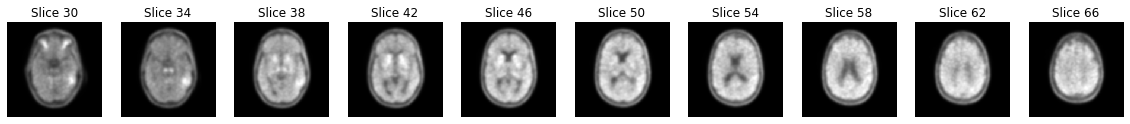

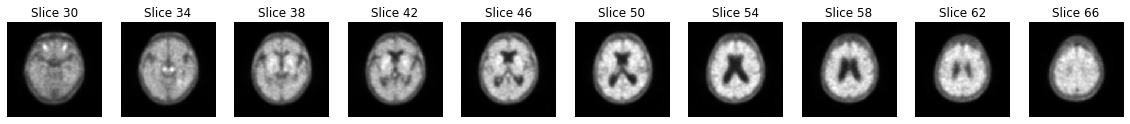

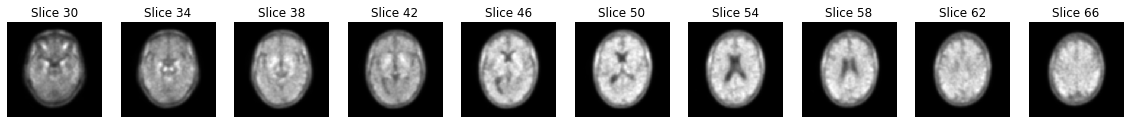

In [5]:
def show_slices(image):
    fig, axes = plt.subplots(1, 10, figsize = (20, 20))
    for i in range(10):
        axes[i].imshow(image[:, : ,(30 + 4 * i)].T, cmap="gray", origin="lower")
        axes[i].axis('off')
        axes[i].set_title('Slice {}'.format(30 + 4 * i))

x_tmp, x_test, y_tmp, y_test = train_test_split(ims, 
                                                group, 
                                                test_size = .1, 
                                                shuffle = True, 
                                                stratify = group, 
                                                random_state = seed)
# false CN
show_slices(x_test[-2,:,:,:,0])
# correct AD
show_slices(x_test[-5,:,:,:,0])
# correct CN
show_slices(x_test[0,:,:,:,0])

# Look at EMCI/LMCI data

In [6]:
dir = ('C:/Users/Ben/Desktop/MCI/Data/') # change this to directory with PET images     
files = os.listdir(dir)
# read in CSV description of downloaded PET scans
df = pd.read_csv('C:/Users/Ben/Desktop/MCI/Tau_EMCI_LMCI_4_08_2021.csv')
# create x and y arrays
group = []
for i in range(len(files)):
    idx = files[i][5:15]
    group.append(df.loc[df.Subject==idx,'Group'].values[0]) 
group = ((np.array(group) == 'LMCI') / 1)
ims = np.array([nib.load(dir + file).get_fdata() for file in files])
ims = torch.from_numpy(ims).float()

y_hat = []
with torch.no_grad():
    for _ in range(len(os.listdir(model_path))):
        z_slice = np.int(os.listdir(model_path)[_][-2:])
        x_test = torch.moveaxis(ims[:,:,:,z_slice], -1, 1)
        y_test = group
        for i in range(len(x_test)):
            x_test[i] -= torch.min(x_test[i])
            x_test[i] /= torch.max(x_test[i])
        test_loader = DataLoader(ADNIDataset(x_test, y_test), batch_size=1, num_workers=0, shuffle=False)
        all_preds = []
        all_labels = []
        model = ClassificationModel2D()
        model.load_state_dict(torch.load(model_path + '/' + os.listdir(model_path)[_]))
        model.eval()
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]
            img = img.to(torch.device('cpu'))
            output = model.forward(img)
            pred = torch.argmax(F.softmax(output, dim=1))
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
        print(all_preds)
        print(all_labels)
        print(classification_report(all_labels, all_preds))
        y_hat.append(all_preds)
        del model
y_test = y_test.astype(int)        
y_hat = ((np.mean(y_hat, axis = 0) >= .5)/1).astype(int)
print(y_test)
print(y_hat)
print(classification_report(y_test, y_hat))

[0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
[1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1]
              precision    recall  f1-score   support

           0       0.73      0.75      0.74        71
           1       0.36      0.33      0.34        30

    accuracy                           0.62       101
   macro avg       0.54      0.54      0.54       101
weighted avg       0.62      0.62      0.62       101

[0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0

[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1]
              precision    recall  f1-score   support

           0       0.74      0.89      0.81        71
           1       0.50      0.27      0.35        30

    accuracy                           0.70       101
   macro avg       0.62      0.58      0.58       101
weighted avg       0.67      0.70      0.67       101

[1 1 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 